In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
pip install keras_metrics

In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
# importing all necessary libraries to run the code
import re,string
import numpy as np
import pandas as pd
import keras_metrics
import tensorflow.keras
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation,Embedding,GlobalMaxPooling1D
# using the variable sw to hold all stopwords that are in English
sw = stopwords.words('english')

Using TensorFlow backend.


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=0Bz8a_Dbh9Qhbd2JNdDBsQUdocVU' # The shareable link

In [8]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

0Bz8a_Dbh9Qhbd2JNdDBsQUdocVU


In [0]:
import gzip
import pandas as pd
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv') 
with open('Filename.csv', 'rb') as fd:
  gzip_fd = gzip.GzipFile(fileobj=fd)
  data = pd.read_csv(gzip_fd, nrows=1400000) 
#df3 = pd.read_csv('Filename.csv')# Dataset is now stored in a Pandas Dataframe

In [10]:
data.columns=['Target','Headline','HeadlineDetail','HeadlineBody']
data.head(2)

,Target,Headline,HeadlineDetail,HeadlineBody
0,6.0,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...
1,3.0,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...


In [0]:
data['text']= data['Headline']+ ' '+data['HeadlineBody']+ ' '+data['HeadlineDetail']

In [12]:
data=data.dropna()
data.head(2)

,Target,Headline,HeadlineDetail,HeadlineBody,text
0,6.0,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...,What is the best off-road motorcycle trail ? i...
1,3.0,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...,What is Trans Fat? How to reduce that? Trans f...


In [13]:
data.isnull().sum()

Target            0
Headline          0
HeadlineDetail    0
HeadlineBody      0
text              0
dtype: int64

In [14]:
#applying pre-processing steps to remove stopwords and words of size less than 2
data['text'] = data['text'].apply(lambda x: x.split())
wordsEng = stopwords.words('english')
data['text'] = data['text'].apply(lambda x:[item for item in x if item not in wordsEng])
data['text'] = data['text'].apply(lambda x: [w for w in x if len(w)>2])
data['text'] = data['text'].apply(lambda x: " ".join(x))
data.head(2)

,Target,Headline,HeadlineDetail,HeadlineBody,text
0,6.0,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...,What best off-road motorcycle trail hear mojav...
1,3.0,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...,What Trans Fat? How reduce that? Trans fats oc...


In [0]:
data.reset_index(inplace=True)

In [0]:
#removing airline company names as pre-processing
testList=[]
def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)


for t in range(len(data)):
    testList.append(strip_all_entities(strip_links(data['text'][t])))

In [17]:
#converting testList[] list into dataframe for further processing
dat = pd.DataFrame(np.array(testList))
dat.head(2)

,0
0,What best off road motorcycle trail hear mojav...
1,What Trans Fat How reduce that Trans fats occu...


In [0]:
# applying pre-processing to remove special symbols, numbers and converting into lower case
sw = stopwords.words('english')
twitterSentiment=[]
for i in range(len(dat)):
    review = re.sub('[^a-zA-Z]', ' ',dat[0][i])
    review = re.sub('[/(){}\[\]\|@!,;]', ' ',dat[0][i])
    review = re.sub('[^0-9a-zA-Z #+_♥️]', ' ',dat[0][i])#Remove bad symbols
    
    review = re.sub(r'\d+', '',review)
    review = review.lower()
    review = review.split()

    review = [token for token in review if token not in sw]
    review=' '.join(review)
    review=' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",review).split())
    twitterSentiment.append(review)

In [19]:
#converting twitterSentiment[] list into dataframe for serving it to keras tokenizer
dataSetFinal = pd.DataFrame(np.array(twitterSentiment))
dataSetFinal.head(5)

,0
0,best road motorcycle trail hear mojave road am...
1,trans fat reduce trans fats occur manufactured...
2,many planes fedex according www fedex com web ...
3,san francisco bay area make sense rent buy ren...
4,best way clean keyboard commercial kits availa...


In [0]:
tokenizer = tensorflow.keras.preprocessing.text.Tokenizer(num_words=7500, lower=True,split=' ',filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(dataSetFinal[0].values)
#print(tokenizer.word_index)  # To see the dicstionary
X = tokenizer.texts_to_sequences(dataSetFinal[0].values)
X = tensorflow.keras.preprocessing.sequence.pad_sequences(X)

In [21]:
from keras import optimizers
from keras import regularizers
from keras import optimizers
from keras import backend as K
print("training CNN ...")
#Deep Learning Network Structure
model = Sequential()
model.add(Embedding(7500,300, input_length=X.shape[1]))
model.add(Conv1D(64, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
model.add(Dense(10, activation='softmax'))  #multi-label (k-hot encoding)

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy','mae',keras_metrics.precision(), keras_metrics.recall()])
model.summary()

training CNN ...





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 752, 300)          2250000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 752, 64)           134464    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 376, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 376, 64)           28736     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
__________________

In [0]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

In [23]:
#batch_size=64
Y = pd.get_dummies(data['Target']).values
X_train, X_valid, Y_train, Y_valid = train_test_split(X,Y, test_size = 0.30)
#Here we train the Network.

#model training
hist = model.fit(X_train, Y_train, batch_size=256, epochs=8, callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=2)
hist



Train on 474801 samples, validate on 52756 samples





Epoch 1/8
 - 116s - loss: 0.1752 - acc: 0.9400 - mean_absolute_error: 0.0966 - precision: 0.7791 - recall: 0.3707 - val_loss: 0.1417 - val_acc: 0.9504 - val_mean_absolute_error: 0.0776 - val_precision: 0.8082 - val_recall: 0.4661
Epoch 2/8
 - 110s - loss: 0.1470 - acc: 0.9491 - mean_absolute_error: 0.0809 - precision: 0.7891 - recall: 0.4569 - val_loss: 0.1369 - val_acc: 0.9516 - val_mean_absolute_error: 0.0756 - val_precision: 0.7812 - val_recall: 0.4940
Epoch 3/8
 - 113s - loss: 0.1396 - acc: 0.9514 - mean_absolute_error: 0.0770 - precision: 0.7940 - recall: 0.4846 - val_loss: 0.1361 - val_acc: 0.9519 - val_mean_absolute_error: 0.0755 - val_precision: 0.7990 - val_recall: 0.4860
Epoch 4/8
 - 112s - loss: 0.1338 - acc: 0.9534 - mean_absolute_error: 0.0737 - precision: 0.7961 - recall: 0.5080 - val_loss: 0.1369 - val_acc: 0.9516 - val_mean_absolute_error: 0.0736 - val_precision: 0.7603 - val_recall: 0.5266
Epoch 5/8
 - 110s - lo

In [24]:
score=[]
score=model.evaluate(X_valid,Y_valid,verbose=2,batch_size=256)
#keras.metrics.binary_accuracy(Y_valid,pred)
print("score: %.2f" %(score[0]))
print("validation accuracy: %.2f" % (score[1]))
print("recall: %.2f" %(score[4]))
print("Precision: %.2f" % (score[3]))

score: 0.14
validation accuracy: 0.95
recall: 0.52
Precision: 0.76


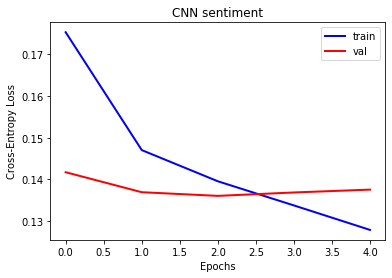

In [25]:
#generate plots
from google.colab import files
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.savefig('training & validation LossYAhooQAPT.pdf')
files.download('training & validation LossYAhooQAPT.pdf') 
plt.show()

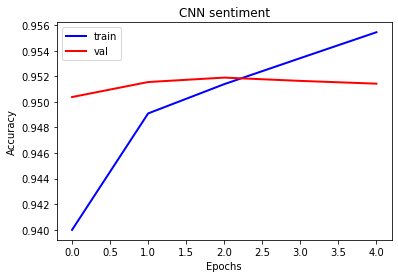

In [27]:
plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.savefig('training & validation accuracyYAhooQAPT.pdf')
files.download('training & validation accuracyYAhooQAPT.pdf')
plt.show()